# Consumption of Animal Products in Mainland China
# 中国大陆动物产品的消费情况

## Ready to work  准备

### Import Libraries 导入工具库

In [1]:
# import necessary libs

import os
import time
import datetime
import json
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms

import seaborn as sns

from scipy import stats

from bs4 import BeautifulSoup

import folium
from folium import plugins

from matplotlib_venn import venn2, venn3, venn3_circles

%matplotlib inline

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

In [2]:
# what is the relevant path of root
root_where = '../../'

# print('+++++++++ Attention ++++++++++')
# print(f'The root is set as "{root_where}" relevant to this file.' )
# print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
# print('+++++++++++++++++++++++++++++')
# print('')

LOCAL_ROOT = os.path.abspath(root_where)

DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
DATA_FAO = os.path.join(DATA_BASE, 'FAO')
DATA_NBS = os.path.join(DATA_BASE, 'NBS')
DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')

NBS_meta = os.path.join(DATA_NBS, 'metadata')

FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'

# print(f'Root director: {LOCAL_ROOT}')
# print(f'Data director: {DATA_BASE}')
# print(f'FAO data director: {DATA_FAO}')
# print(f'NBS data director: {DATA_NBS}')
# print(f'Hybrids data director: {DATA_hybrids}')
# print('')
# print(f'NBS metadata director: {NBS_meta}')
# print('')
# print(f'FAO metadata director: {FAO_meta}')
# print(f'FAO local description file: {FAO_description_path}')
# print(f'FAO local data zip: {FAO_BULK_zip}')
# print('')

SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
print(f'Suffix of raw FAO data file name: {SUFFIX}')

Suffix of raw FAO data file name: _E_All_Data_(Normalized)


In [3]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (3,8)
DPI = 144

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# Color setting ===================================================================

# 猪，牛，羊，禽肉，鱼，蛋，奶
Pig_pink = '#ffab91'
Bovine_red = '#c62828'
Lamb_green = '#689f38'
Bird_orange = '#ff6f00'
Aqua_cyan = '#80deea'
Egg_yellow = '#ffc400'
Milk_blue = '#1e88e5'

# 国家
CN_red = "#ff8a65"
OECD_blue = "#80cbc4"
World_gray = "#666666"

# Good Food
GF_brand_gold = '#fdd835'
GF_brand_gray = '#9F888C'

GF_amber1 = '#ffe57f'
GF_amber2 = '#ffab00'

GF_red0 = '#ffebee'
GF_red1 = '#ff8a80'
GF_red2 = '#d50000'

GF_green2 = '#00c853'
GF_green1 = '#b9f6ca'

GF_blue1 = '#82b1ff'
GF_blue2 = '#2962ff'

CLs = [Pig_pink, Bovine_red, Lamb_green, Bird_orange, Aqua_cyan, Egg_yellow,  Milk_blue]

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

In [4]:
path_img = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'
path_map = f'{LOCAL_ROOT}/results/CN_FoodConsumption/map/'
for path in [path_img, path_map]:
    for i in os.listdir(path):
        path_file = os.path.join(path,i)  
        if os.path.isfile(path_file):
              os.remove(path_file)

### Read Data Frame 读取数据

To visualize data to see where people like to eat what kind of animals in different areas of mainland China, we got:
- Dataset _'food consumption per capita of residents in urban regions (2017)'_ and _'food consumption per capita of residents in rural regions (2017)'_ from [China Statistics Bureau](http://www.stats.gov.cn/tjsj/ndsj/2018/indexch.htm), which shows per capita consumption of the main animal products, such as pork, beef, birds meat, aquatic product, egg and milk in different provinces of China. These two table was collected in [this data frame](./data/NBS/FoodConsumption_areas.csv)
- Dataset _'population structure, Birth rate, mortality rate and natural growth rate in urban and rural regions (2017)'_ from China Statistics Bureau, too. This table was collected in [this data frame](./data/NBS/Population_2017.csv)

In [5]:
data = pd.read_csv(DATA_NBS+'/FoodConsumption_areas.csv')
population = pd.read_csv(DATA_NBS+'/Population_2017.csv')
geoname = pd.read_csv(NBS_meta+'/GeoNameSheet_cn.csv')
display(population)
display(data.head())
display(geoname.head())
# display(data.head())
# display(geoname.head())

,Area,Year,Total Population - Both sexes,Urban population,Rural population
0,"China, mainland",2017,139008,81347,57661
1,Beijing,2017,2171,1878,293
2,Tianjin,2017,1557,1291,266
3,Hebei,2017,7520,4136,3383
4,Shanxi,2017,3702,2123,1579
5,Neimenggu,2017,2529,1568,961
6,Liaoning,2017,4369,2949,1420
7,Jilin,2017,2717,1539,1178
8,Heilongjiang,2017,3789,2250,1538
9,Shanghai,2017,2418,2121,297


,Area,Year,Urban or Rural,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar
0,"China, mainland",2015,Urban,112.6,101.6,11.1,10.7,104.4,28.9,20.7,2.4,1.5,9.4,14.7,10.5,17.1,55.1,1.3
1,Beijing,2015,Urban,88.5,79.2,11.0,11.0,102.1,26.4,14.0,3.6,3.1,6.3,10.3,14.0,28.9,71.5,0.8
2,Tianjin,2015,Urban,118.4,109.0,10.7,10.7,116.7,26.1,16.0,3.0,3.2,5.2,17.6,17.1,18.5,74.0,1.3
3,Hebei,2015,Urban,115.8,105.7,9.7,9.6,94.7,22.8,13.6,2.1,1.9,5.2,7.5,13.7,21.2,63.4,1.0
4,Shanxi,2015,Urban,110.7,98.2,8.2,8.1,85.2,16.7,10.6,1.0,1.7,2.7,4.9,11.4,20.6,60.1,0.8


,Area Code,Area,Region
0,41,"China, mainland",East Asia
1,1001,Beijing,North China
2,1002,Tianjin,North China
3,1003,Hebei,North China
4,1004,Shanxi,North China


__各地区的人均消费量 - DataFrame 'df_percapita'__

__人口数 - DataFrame 'df_population'__

In [6]:
df_percapita = pd.merge(geoname, data, on='Area', how='outer')
df_percapita = df_percapita[df_percapita['Year']==2017]
df_percapita = df_percapita.sort_values(['Area Code','Urban or Rural'])
df_percapita.reset_index(inplace=True)
df_percapita = df_percapita.drop(columns=['index'])
display('Unint: kg/capita/year')
display(df_percapita.head(6))

df_population =  pd.merge(geoname, population, on='Area', how='outer')
display('Unit: 10,000 people')
display(df_population.head())

'Unint: kg/capita/year'

,Area Code,Area,Region,Year,Urban or Rural,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar
0,41,"China, mainland",East Asia,2017,Rural,154.6,144.8,10.1,9.2,90.2,23.6,19.5,0.9,1.0,7.9,7.4,8.9,6.9,38.4,1.4
1,41,"China, mainland",East Asia,2017,Urban,109.7,98.6,10.7,10.3,106.7,29.2,20.6,2.6,1.6,9.7,14.8,10.9,16.5,59.9,1.3
2,1001,Beijing,North China,2017,Rural,96.7,86.9,9.0,9.0,88.7,22.2,14.4,1.7,3.0,4.0,5.6,11.8,12.9,51.7,1.2
3,1001,Beijing,North China,2017,Urban,72.4,64.0,8.2,8.2,92.4,23.1,12.4,3.1,2.8,5.7,9.0,12.1,24.0,65.8,1.0
4,1002,Tianjin,North China,2017,Rural,153.9,142.9,12.8,12.7,99.0,22.0,14.4,0.9,2.3,4.1,12.6,16.7,12.0,81.8,1.7
5,1002,Tianjin,North China,2017,Urban,112.9,102.6,10.5,10.4,120.0,27.5,16.2,3.5,3.3,6.0,17.8,18.6,18.4,86.1,1.4


'Unit: 10,000 people'

,Area Code,Area,Region,Year,Total Population - Both sexes,Urban population,Rural population
0,41,"China, mainland",East Asia,2017,139008,81347,57661
1,1001,Beijing,North China,2017,2171,1878,293
2,1002,Tianjin,North China,2017,1557,1291,266
3,1003,Hebei,North China,2017,7520,4136,3383
4,1004,Shanxi,North China,2017,3702,2123,1579


### Data preprocessing 数据预处理

1. 除上述已给出的各地区城镇人均消费量，各地区农村人均消费量，以及各地区城镇和农村的人口数量，计算下列数据：
    - ```各地区城镇消费总量 = 各地城镇人均消费量 × 各地城镇人口（单位：万吨）```
    - ```各地区农村消费总量 = 各地农村人均消费量 × 各地农村人口（单位：万吨）```
    - ```各地区消费总量 = 各地城镇消费总量 + 各地农村消费总量（单位：万吨）```

    
- 所得 DataFrame 保存为变量`df_total` 。

In [7]:
areas = geoname.Area.unique()

# 创建表格
df_total = pd.DataFrame()
cols_meta = df_percapita.columns[:5]
cols_items = df_percapita.columns[5:]
for col in cols_meta:
    df_total[col]=df_percapita[col]    
    
# 计算各地区城镇消费总量
for col in cols_items:
    for area in areas:
        df_total.loc[(df_total['Urban or Rural']=='Rural') & (df_total['Area']==area),col]\
        =df_percapita.loc[(df_percapita['Urban or Rural']=='Rural') & (df_percapita['Area']==area),col].values[0]\
        *df_population.loc[df_population['Area']==area,'Rural population'].values[0]/1000

# 计算各地区农村消费总量
for col in cols_items:
    for area in areas:
        df_total.loc[(df_total['Urban or Rural']=='Urban') & (df_total['Area']==area),col]\
        =df_percapita.loc[(df_percapita['Urban or Rural']=='Urban') & (df_percapita['Area']==area),col].values[0]\
        *df_population.loc[df_population['Area']==area,'Urban population'].values[0]/1000
# display('Unit: 10,000 t')
# df_total.tail()

# 创建表格
df_national_total = pd.DataFrame()
cols_meta = df_total.columns[:4]
cols_items = df_total.columns[5:]
for col in cols_meta:
    df_national_total[col]=df_population[col]
df_national_total['Urban or Rural']='Urban & Rural'
areas = geoname.Area.unique()

# 补充各地区消费总量
for col in cols_items:
    for area in areas:
        df_national_total.loc[df_national_total['Area']==area,col]\
        =df_total.loc[(df_total['Urban or Rural']=='Rural') & (df_total['Area']==area),col].values[0]\
        +df_total.loc[(df_total['Urban or Rural']=='Urban') & (df_total['Area']==area),col].values[0]

# 合并表格后，df_total 的每个 item 含以下数据：
#    各地区城镇消费总量 
#    各地区农村消费总量
#    各地区消费总量
df_total = pd.concat([df_total, df_national_total], sort = False)
df_total = df_total.sort_values(['Area Code','Urban or Rural'])
df_total.reset_index(inplace=True)
df_total = df_total.drop(columns=['index'])
display('Unit: 10,000 t')
display(df_total.tail(6))

'Unit: 10,000 t'

,Area Code,Area,Region,Year,Urban or Rural,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar
90,1030,Ningxia,Northwest China,2017,Rural,36.7647,34.7844,2.2099,2.2099,22.0703,4.0467,1.7220,0.9471,1.2054,1.6933,0.3731,1.1767,2.1525,18.3393,0.3444
91,1030,Ningxia,Northwest China,2017,Urban,37.8805,35.2340,3.0020,3.0020,38.1570,6.7545,2.6070,1.5405,2.0145,2.4095,1.5010,2.6860,7.3865,30.7705,0.5530
92,1030,Ningxia,Northwest China,2017,Urban & Rural,74.6452,70.0184,5.2119,5.2119,60.2273,10.8012,4.3290,2.4876,3.2199,4.1028,1.8741,3.8627,9.5390,49.1098,0.8974
93,1031,Xinjiang,Northwest China,2017,Rural,224.2018,222.5924,17.7034,17.5796,102.2588,23.8934,2.2284,4.7044,16.2178,5.5710,1.2380,5.5710,16.3416,61.5286,1.2380
94,1031,Xinjiang,Northwest China,2017,Urban,159.9275,152.3234,16.8980,16.8980,141.3397,29.3301,7.8455,6.6385,12.0700,9.2939,7.3627,10.8630,36.6928,86.6626,1.8105
95,1031,Xinjiang,Northwest China,2017,Urban & Rural,384.1293,374.9158,34.6014,34.4776,243.5985,53.2235,10.0739,11.3429,28.2878,14.8649,8.6007,16.4340,53.0344,148.1912,3.0485


2. 将各地区的消费总量经归一化处理（与全国消费总量相比）后，再用其评价各地区对某动物类食品的总消费能力：

    __```各地区消费总量占全国消费总量的比例 = 各地区消费总量 / sum(各地区消费总量)```__

- 将归一化处理后的 DataFrame 保存到变量 __`total_norm`__

In [8]:
# 计算全国总量
cn_total = df_total[(df_total['Area']=='China, mainland') & (df_total['Urban or Rural']=='Urban & Rural')]

# 创建表格
areas_total = df_total[(~df_total['Area'].isin(['China, mainland'])) & (df_total['Urban or Rural']=='Urban & Rural')]
total_norm = pd.DataFrame()
for col in cols_meta:
    total_norm[col] = areas_total[col]

# 计算各地区消费总量占全国消费总量的百分比（归一化处理）
for col in cols_items:
    total_norm[col] = areas_total[col]/cn_total[col].values[0]

display(total_norm.head())

,Area Code,Area,Region,Year,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar
5,1001,Beijing,North China,2017,0.009211,0.008898,0.012415,0.013181,0.014374,0.013352,0.009823,0.023994,0.032678,0.009543,0.011372,0.018703,0.028074,0.019574,0.011956
8,1002,Tianjin,North China,2017,0.010466,0.010413,0.011674,0.012281,0.013058,0.011069,0.008837,0.018064,0.025941,0.007100,0.016148,0.020327,0.015486,0.018755,0.012117
11,1003,Hebei,North China,2017,0.052088,0.052274,0.048029,0.050498,0.048219,0.039859,0.033405,0.044108,0.058052,0.025646,0.027714,0.076031,0.065576,0.065787,0.043950
14,1004,Shanxi,North China,2017,0.027713,0.026818,0.020607,0.021763,0.020949,0.014026,0.012585,0.011677,0.026783,0.007104,0.005589,0.028946,0.032990,0.027438,0.020407
17,1005,Neimenggu,North China,2017,0.021470,0.021468,0.014661,0.015056,0.016106,0.022943,0.015269,0.041767,0.121080,0.010831,0.007730,0.016592,0.033655,0.020413,0.020153


3. 将各地区的人均消费各动物产品量归一化处理（与占其主要食品消费总量相比）后，再用其评价某地区城镇（或农村）对某动物类食品的人均消费能力：

    __```各地区城镇（或农村）人均消费某动物产品占其主要食品消费量的比例 = 各地区城镇（或农村）人均消费某动物产品量 / 各地区城镇（或农村）人均主要食品消费量```__
    
- 将归一化处理后的 DataFrame 保存到变量 __`percapita_norm`__

In [9]:
df = df_percapita.copy()
# display(df.head())

# 分类：

# 肉类
df['Meat']=df['Pigmeat']+ df['Bovine Meat']+df['Mutton & Goat Meat']+df['Poultry Meat']
# 水产：'Fish, Seafood'，不需要处理
# 鸡蛋：'Eggs'，不需要处理
# 牛奶：'Milk'不需要处理

# 动物性食品合计
df['Animal Products']=df['Meat']+df['Fish, Seafood']+df['Eggs']+df['Milk']

# 非动物性食品
df['Non-animal Products']=df['Main Grain']+df['Edible Oil, vegetable']+df['Vegetable & Fungus']+df['Melon & Fruit']+df['Sugar']

# 合计:
df['Sum'] = df['Non-animal Products']+df['Meat']+df['Fish, Seafood']+df['Eggs']+df['Milk']

percapita_norm=df.copy()
# 归一化处理：
for col in df.columns[5:]:
    percapita_norm[col] = df[col]/df['Sum']
display(percapita_norm.head())

,Area Code,Area,Region,Year,Urban or Rural,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar,Meat,Animal Products,Non-animal Products,Sum
0,41,"China, mainland",East Asia,2017,Rural,0.446434,0.418135,0.029165,0.026567,0.260468,0.068149,0.056310,0.002599,0.002888,0.022813,0.021369,0.025700,0.019925,0.110887,0.004043,0.084609,0.151603,0.848397,1.0
1,41,"China, mainland",East Asia,2017,Urban,0.300878,0.270433,0.029347,0.028250,0.292649,0.080088,0.056500,0.007131,0.004388,0.026604,0.040592,0.029896,0.045255,0.164290,0.003566,0.094624,0.210368,0.789632,1.0
2,1001,Beijing,North China,2017,Rural,0.321583,0.288992,0.029930,0.029930,0.294978,0.073828,0.047888,0.005653,0.009977,0.013302,0.018623,0.039242,0.042900,0.171932,0.003991,0.076821,0.177586,0.822414,1.0
3,1001,Beijing,North China,2017,Urban,0.234380,0.207187,0.026546,0.026546,0.299126,0.074781,0.040142,0.010036,0.009064,0.018453,0.029136,0.039171,0.077695,0.213014,0.003237,0.077695,0.223697,0.776303,1.0
4,1002,Tianjin,North China,2017,Rural,0.373453,0.346760,0.031060,0.030818,0.240233,0.053385,0.034943,0.002184,0.005581,0.009949,0.030575,0.040524,0.029119,0.198496,0.004125,0.052657,0.152876,0.847124,1.0


## Results 结果

### 各地区消费总量在全国的占比

- Draw Atlas and Venns by Using __`total_norm`__

#### Over View with Bar plots and Pie

In [10]:
# 各地消费量再全国的占比
def total_consumption(
    year,
):
    df = total_norm.copy()

    items = ['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk',]

    df = df[['Area']+items]
    
    
    for i, c in zip(items, CLs): 
        
        # ============= bar
        df = df.sort_values([i], ascending=False, axis=0)
        df.reset_index(inplace=True, drop=True)
        
        fig_size=FIG_size
        title = f"{i} Consumption as a Percentage of Nation in {year}"
        fig = plt.figure(figsize = fig_size,dpi=DPI)
        plt.title(title,  fontsize=TIT_size, y=1.02)
        
        df[['Area', i]].plot.barh(x='Area', width=0.6, color=c, ax=plt.gca())      
        ax = plt.gca()
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.1%}'.format(width), (x+width*1.01, y+0.5), fontsize=LEG_size)
        
        plt.xticks([])
        
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_legend().remove()

        ax = plt.gca().invert_yaxis()

         # === Save img
        path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'+f'01-{title}-bar'+'.png'
        bbox = matplotlib.transforms.Bbox([[-1.5, 0], [fig_size[0]+1.5, fig_size[1]]])
        fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
        print('Img saved as: ' + path)
        
        # ================== pie
        
        pie = df[['Area', i]].head(6)
        sum_of_head = pie.sum(axis=0).tolist()[1]
        others = 1 - sum_of_head
        data = { 'Area':['Others'], i:[others], }
        pie = pd.concat([pie, pd.DataFrame(data, columns=['Area', i])], axis=0)
        
        fig_size = (5,3)
        title = f"{i} Consumption as a Percentage of Nation in {year}"
        fig = plt.figure(figsize = fig_size, dpi=DPI)
        plt.title(title,  fontsize=TIT_size, y=1.2)
        
        pie[i].plot(
            kind='pie',
            startangle=90,     # start angle 90° (Africa)
            shadow=False, 
            autopct='%1.1f%%', # add in percentages
            pctdistance=0.8,
            labels=pie['Area'].values.tolist(), 
            labeldistance = 1.1,
            colors=[GF_red0, GF_red1, GF_red0, GF_red1, GF_red0, GF_red1, GF_brand_gray],   
            fontsize=LEG_size-1
#             explode=explode_list,     
#             subplots=True
        )

        plt.title(title, y=1.12)
        plt.axis('equal') # Sets the pie chart to look like a circle.

#         plt.legend(labels=pie[['Area']].values.tolist(), loc='upper left')

        # === Save img
        path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'+f'01-{title}-pie'+'.png'
        bbox = matplotlib.transforms.Bbox([[-0.2, 0.2], [fig_size[0]-0.5, fig_size[1]-0.2]])
        fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
        print('Img saved as: ' + path)
        

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/01-Pigmeat Consumption as a Percentage of Nation in 2017-bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/01-Pigmeat Consumption as a Percentage of Nation in 2017-pie.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/01-Bovine Meat Consumption as a Percentage of Nation in 2017-bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/01-Bovine Meat Consumption as a Percentage of Nation in 2017-pie.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/01-Mutton & Goat Meat Consumption as a Percentage of Nation in 2017-bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/01-Mutton & Goat Meat Consumption as a Percentage of Nation in 2017-pie.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood

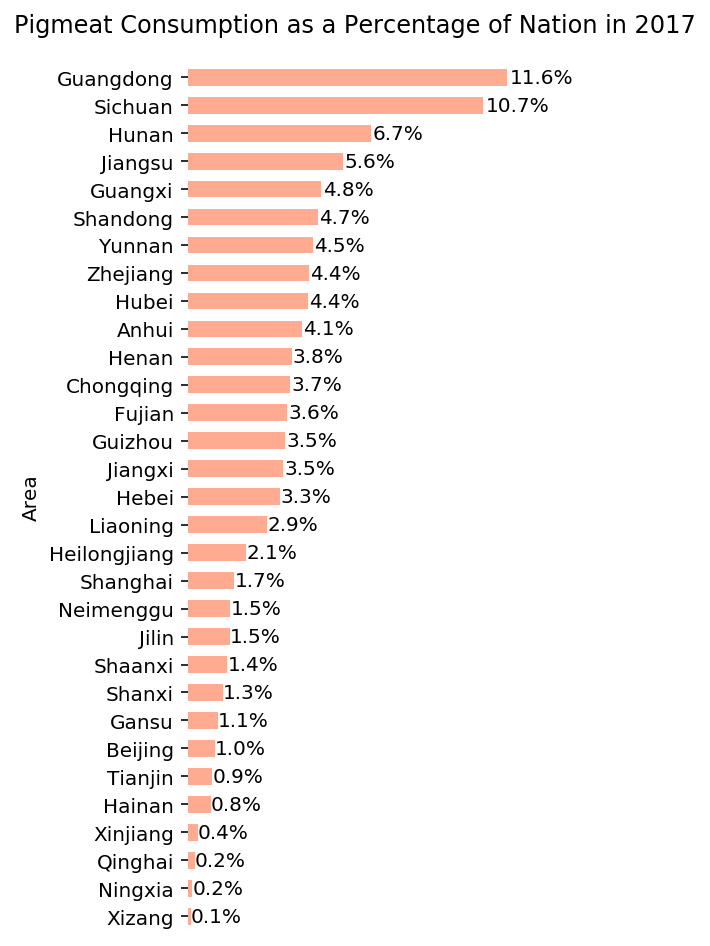

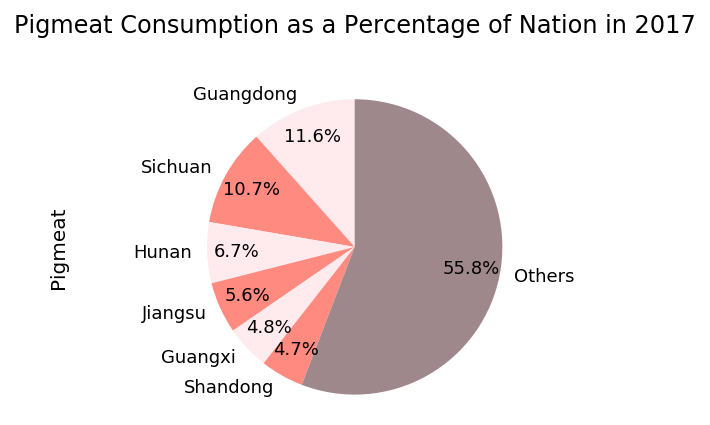

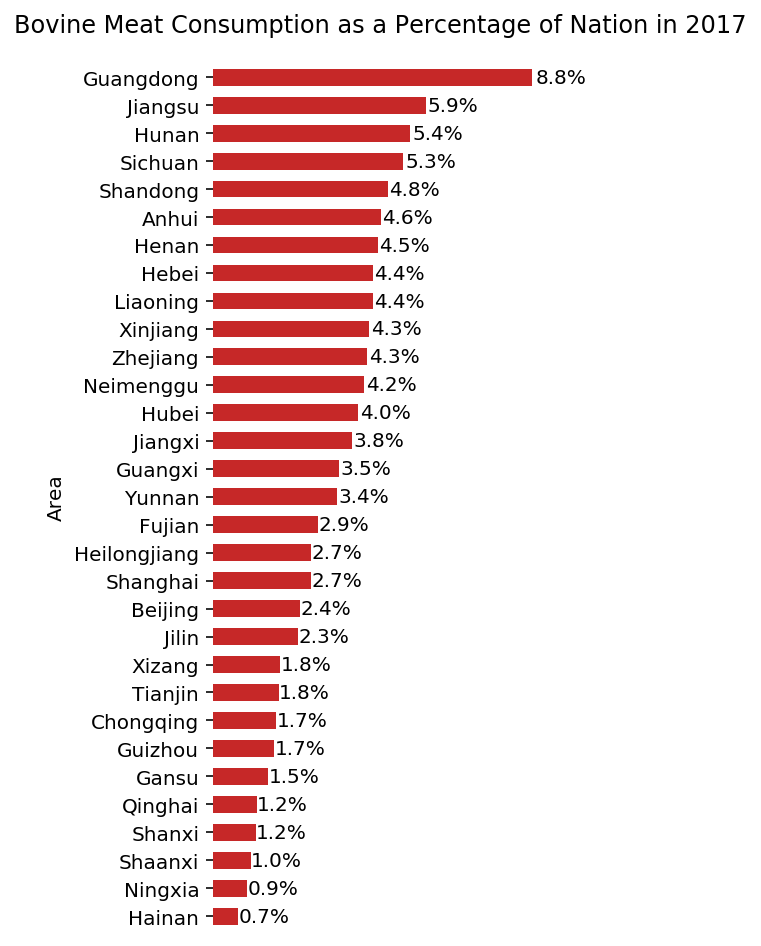

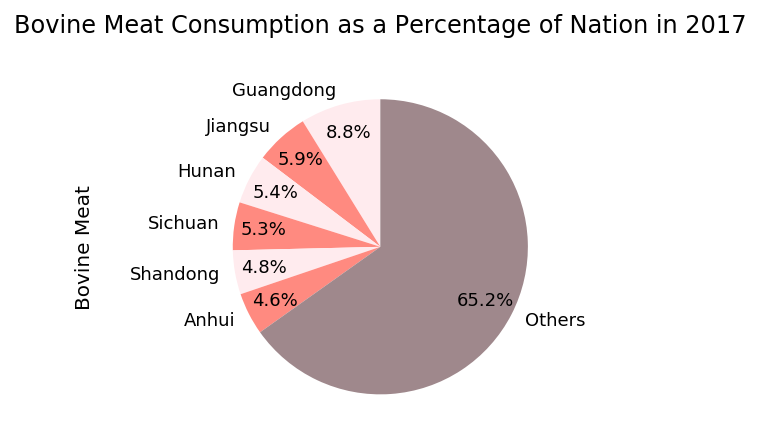

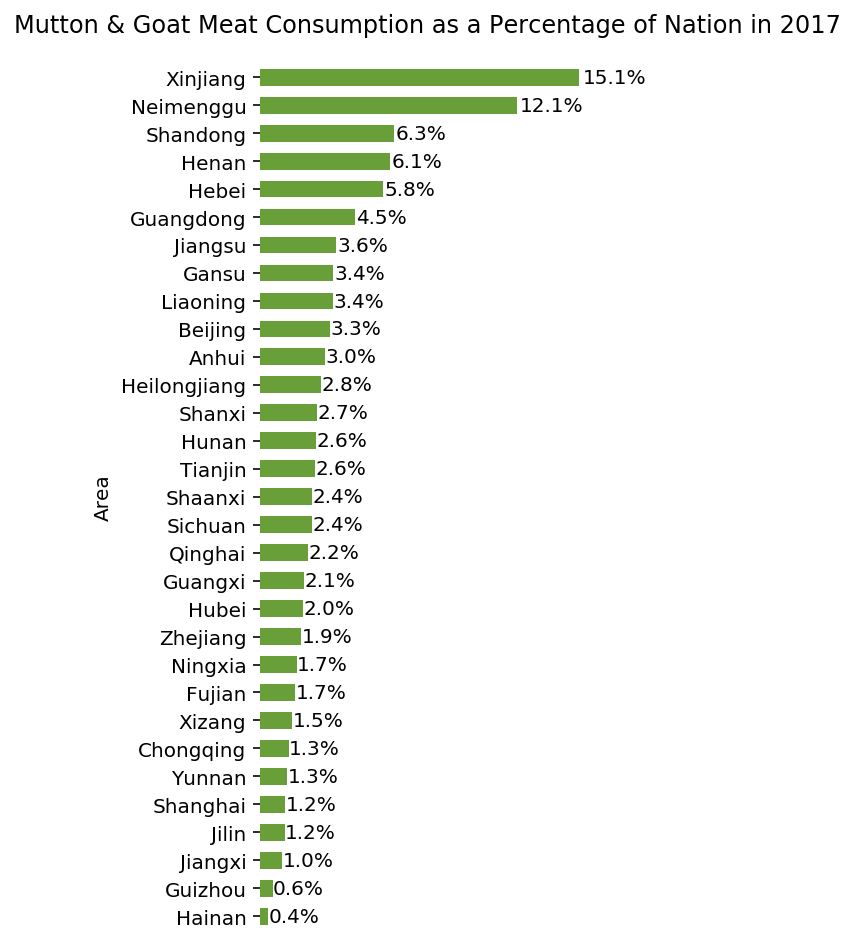

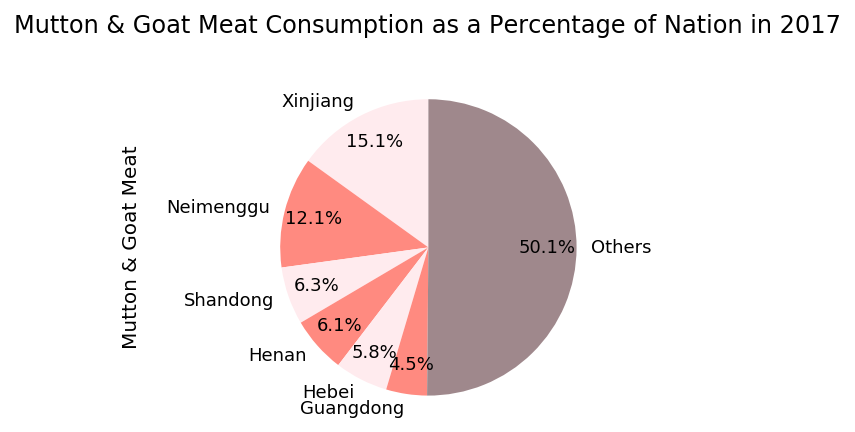

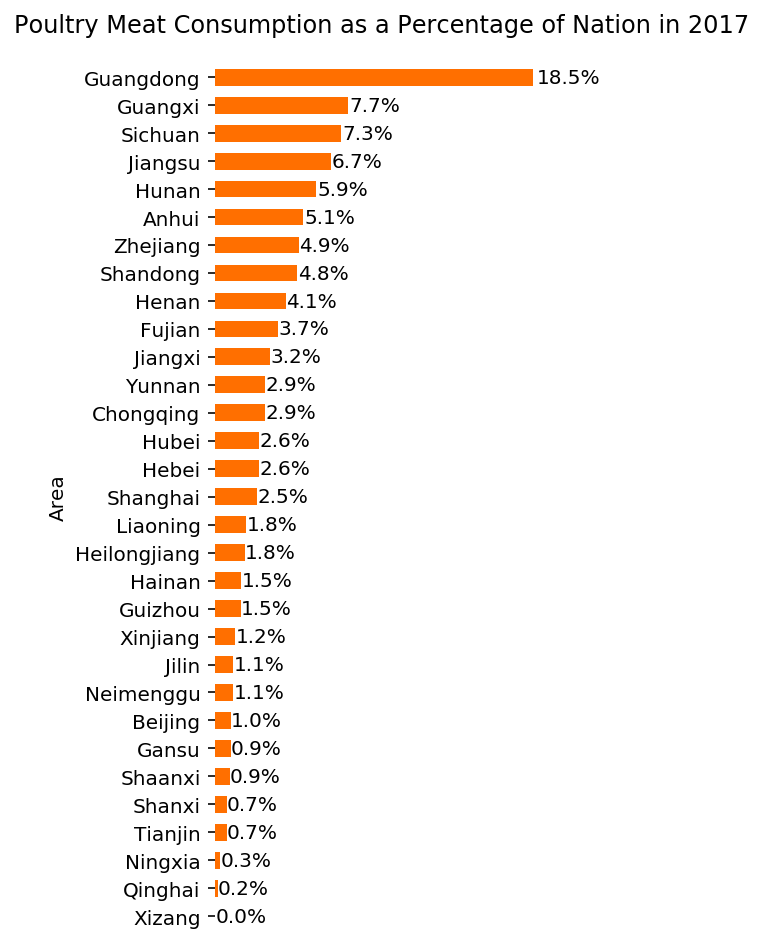

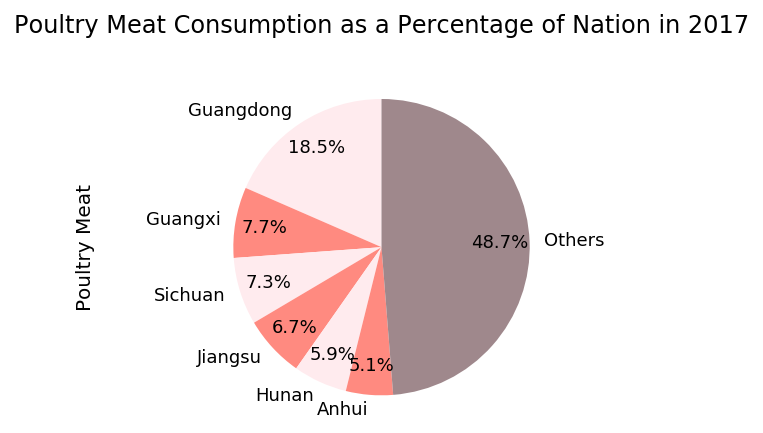

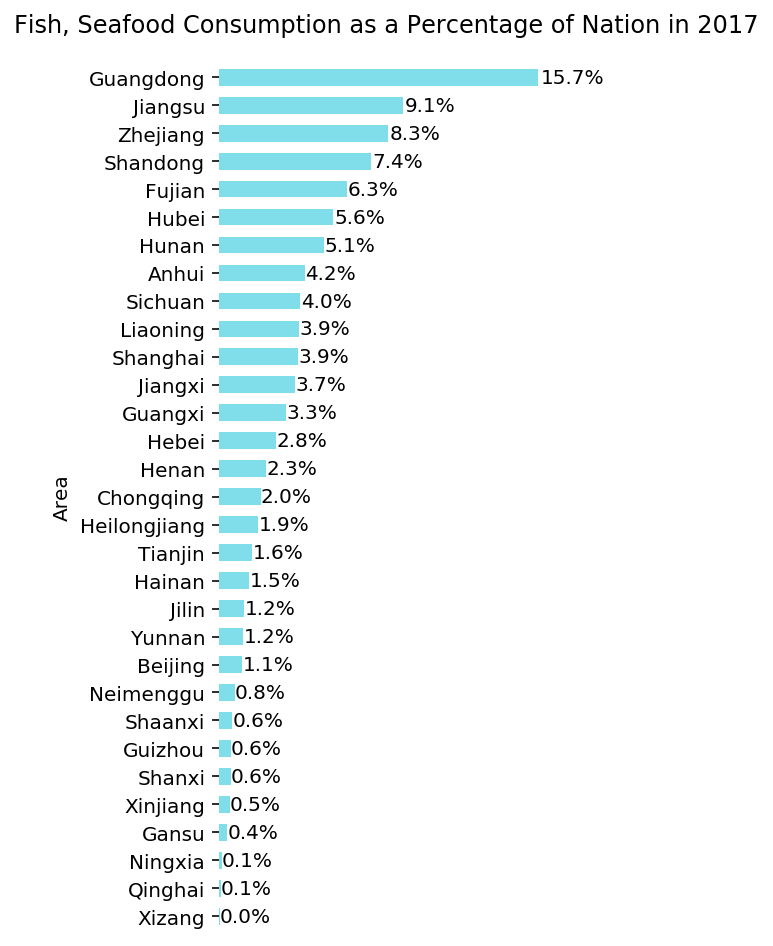

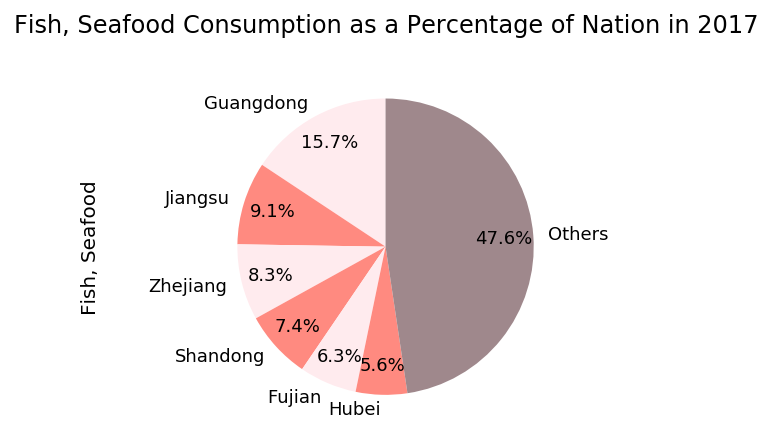

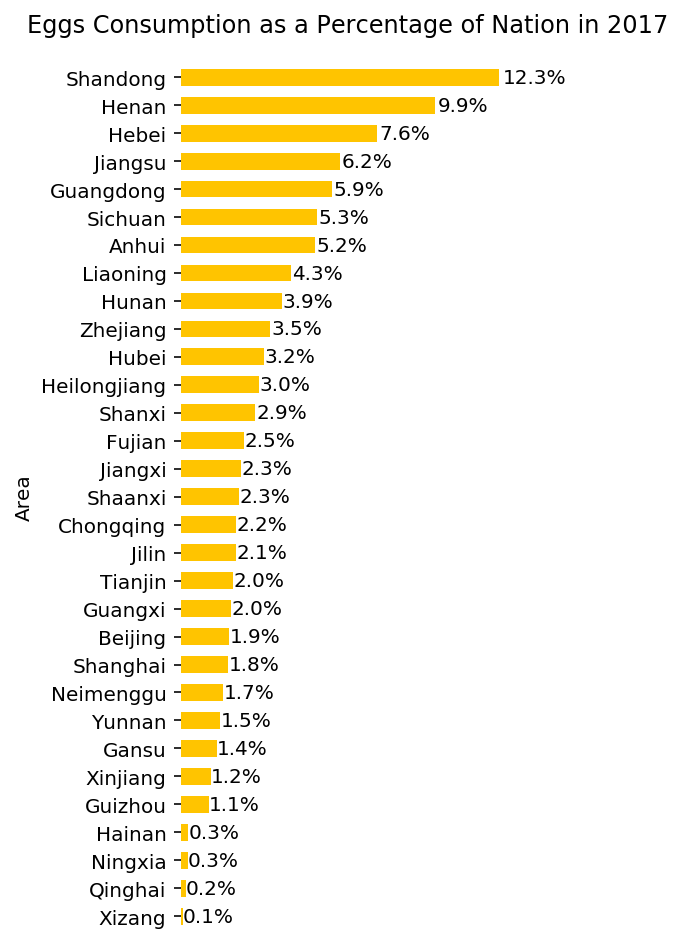

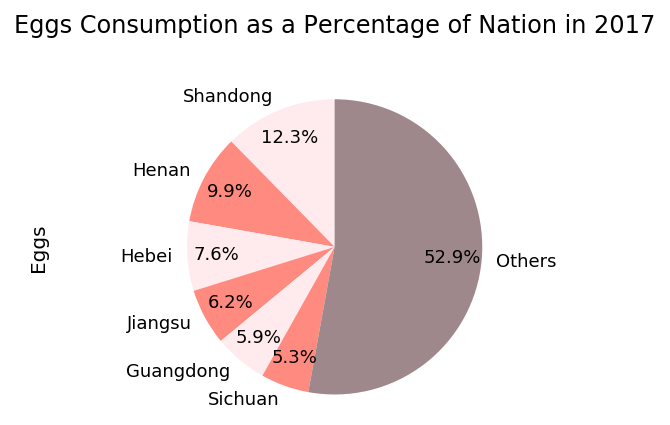

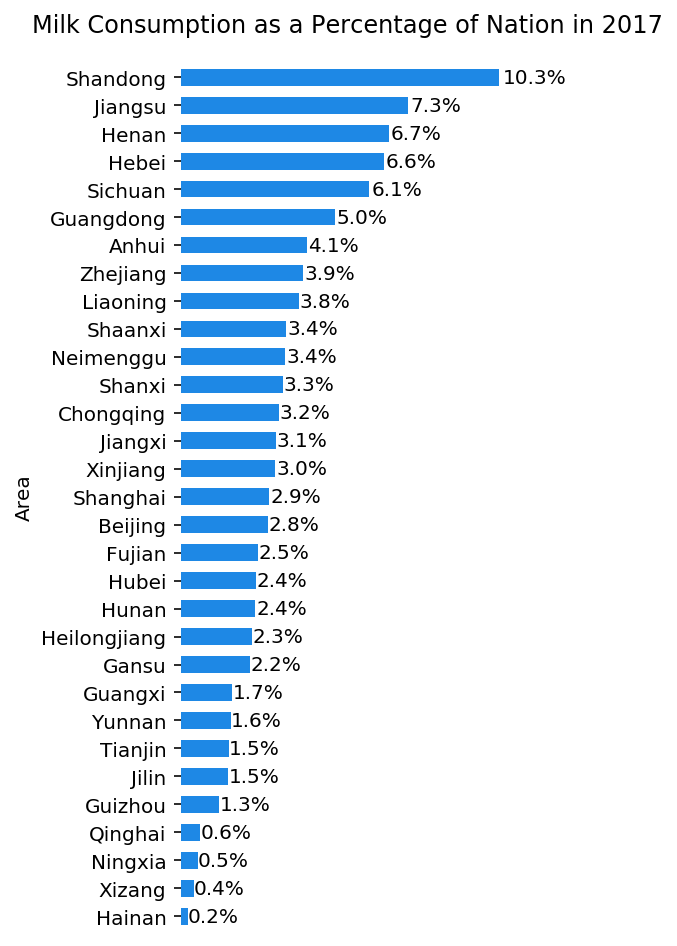

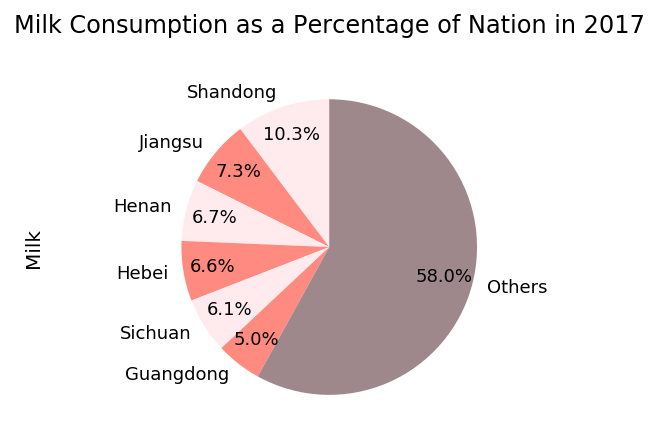

In [11]:
total_consumption(
    year=2017,
)

#### Atlas

In [12]:
def plotAtlas(
    df_,           # data frame, the gross data frame
    items_,        # string, selected item
    year_,         # int, selected year
    geo_data_,     # geojson file
    fill_color_,   # string, select a fill_color strategy in folium
):

    df = total_norm.copy()
    df = df[df['Year']==year_][['Area']+items_]
    df[items_] = df[items_] * 100
    
    for i in items_:
        title = f"{i} Consumption as a Percentage of the Nation in {year_}"
        cn_map = folium.Map( width=1000, height=600, location=[40, 105], zoom_start=4, tiles='Mapbox Bright')
        
        threshold_scale = np.around(np.linspace(0.0, df[i].values.max()+1, num=6, endpoint=True),1)
    
        folium.Choropleth(
            geo_data=geo_data_,
            data=df[['Area', i]],
            name = i,
            columns=['Area', i],
            key_on='feature.properties.NAME',
            threshold_scale=threshold_scale,
            nan_fill_color='gray',
            fill_color=fill_color_,
            fill_opacity=1, 
            line_opacity=0.2,
            legend_name=title,
            show=False,
            highlight=False,
            reset=False
        ).add_to(cn_map)
        
        path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/map/'+f'01-{title}'+'.html'
        cn_map.save(path)
        print('Atala saved as: ' + path)
#         display(cn_map)

__注意：此处输出结果为地图，不能直接在文本中显示地图，请根据结果输出的地址自行查看__

In [13]:
items = ['Pigmeat', 'Bovine Meat','Mutton & Goat Meat','Poultry Meat','Fish, Seafood', 'Eggs', 'Milk']

plotAtlas(
    df_=total_norm,           # data frame, the gross data frame
    items_=items,         # string, selected item
    year_=2017,         # int, selected year
    geo_data_=f'{LOCAL_ROOT}/geojson/cn_provinces.geojson',     # geojson file
    fill_color_='OrRd',   # string, select a fill_color strategy in folium
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/01-Pigmeat Consumption as a Percentage of the Nation in 2017.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/01-Bovine Meat Consumption as a Percentage of the Nation in 2017.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/01-Mutton & Goat Meat Consumption as a Percentage of the Nation in 2017.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/01-Poultry Meat Consumption as a Percentage of the Nation in 2017.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/01-Fish, Seafood Consumption as a Percentage of the Nation in 2017.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/01-Eggs Consumption as a Percentage of the Nation in 2017.html
Atala saved as: /mnt/sda2/_hub/proj

### 各地区城镇和农村的人均消费某动物产品占其主要食品消费量的百分比

Draw Bars and Atlas by Using __`percapita_norm`__

#### Overview with Box plot

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/02-Percentage of Animal Production in Daily intake, Compare between Urban and Raral (2017)-Gross.png


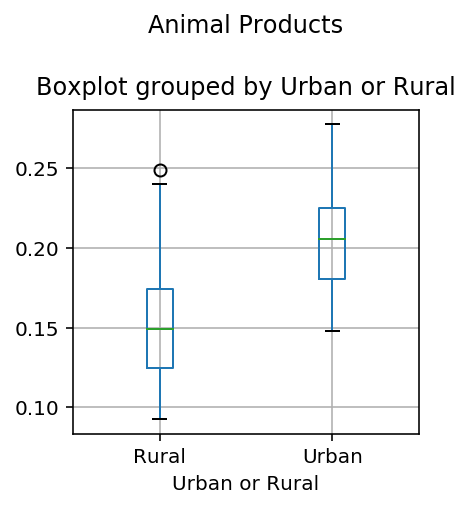

In [14]:
df = percapita_norm.copy()
items = ['Animal Products',]
year = 2017

df = df[['Area', 'Urban or Rural']+items]

fig_size = (3,3)
title = f"Percentage of Animal Production in Daily intake, Compare between Urban and Raral ({year})"
fig = plt.figure(figsize = fig_size,dpi=DPI)
plt.title(title,  fontsize=TIT_size, y=1.2)

box = df.boxplot(column=items, by='Urban or Rural', layout=(2,4), return_type='axes', ax=plt.gca())

path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'+f'02-{title}-Gross'+'.png'
bbox = matplotlib.transforms.Bbox([[-1, -0.5], [fig_size[0]+1, fig_size[1]+1]])
fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
print('Img saved as: ' + path)

/home/sheldon/anaconda3/envs/meat-atlas/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:355: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/02-Percentage of Animal Production in Daily intake, Compare between Urban and Raral (2017).png


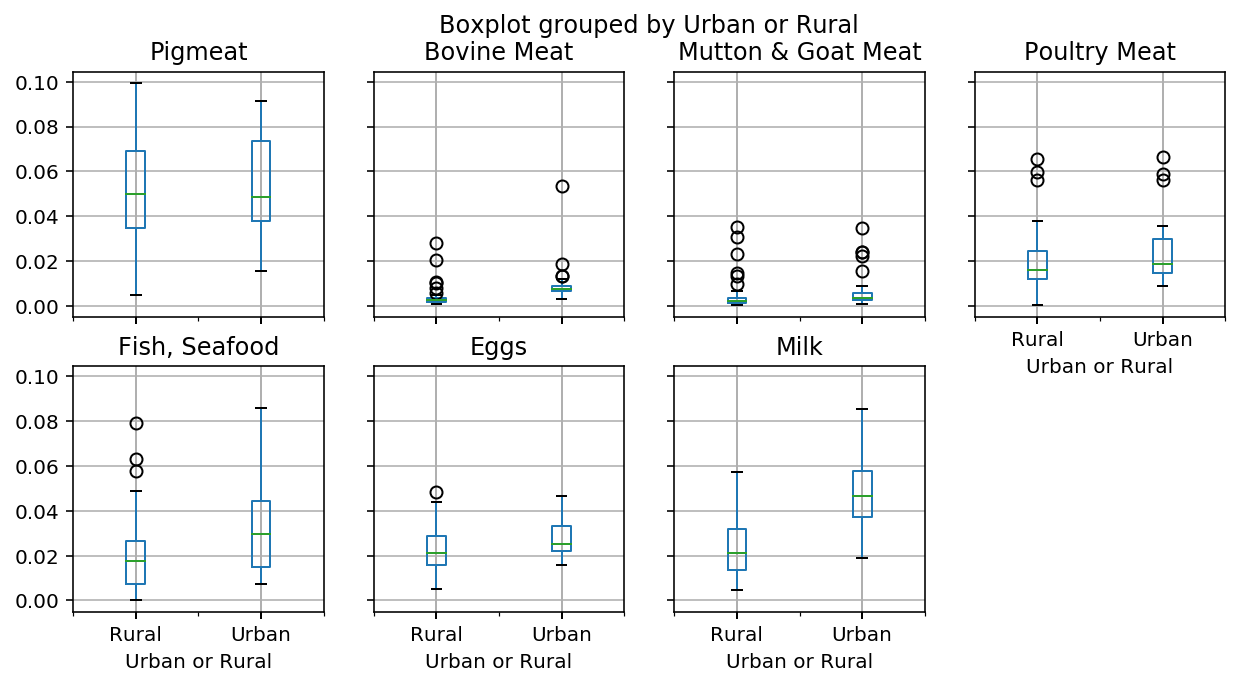

In [15]:
df = percapita_norm.copy()
items = ['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk',]
year = 2017

df = df[['Area', 'Urban or Rural']+items]

fig_size = (10,5)
title = f"Percentage of Animal Production in Daily intake, Compare between Urban and Raral ({year})"
fig = plt.figure(figsize = fig_size, dpi=DPI)
plt.title(title,  fontsize=TIT_size)

box = df.boxplot(column=items, by='Urban or Rural', layout=(2,4), return_type='axes', ax=plt.gca())

path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'+f'02-{title}'+'.png'
bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0], fig_size[1]]])
fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
print('Img saved as: ' + path)

#### Overview with Bar plots

In [16]:
# 各地人均
def pc_consumption(
    urban_or_rural,
    year,
):
    df = percapita_norm.copy()
    df = df[df['Urban or Rural']==urban_or_rural]
    
    df = df[['Area','Animal Products', 'Sum']]
    
    df = df.sort_values(['Animal Products'], ascending=False, axis=0)
    df.reset_index(inplace=True, drop=True)
    display(df.head())
    
    nation_indexes = df.index[df['Area']=='China, mainland'].tolist()
    national_everage_index = nation_indexes[0]
    
    fig_size = FIG_size
    title = f"Percentage of Animal Produced Food in Daily intake ({year}, {urban_or_rural})"
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title,  fontsize=TIT_size, y=1.02)
    
    df[['Area', 'Animal Products']].plot.barh(x='Area', width=0.6, color=GF_brand_gold, ax=plt.gca())
    
    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.1%}'.format(width), (x+width*1.01, y+0.5), fontsize=LEG_size)
    ax.patches[national_everage_index].set_ec('r')
    ax.patches[national_everage_index].set_fc('r')
    
    df[['Area', 'Sum']].plot.barh(x='Area', width=0.6, color="#666666", alpha=0.1, ax = plt.gca())
    plt.xticks([])
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_legend().remove()
    
    ax = plt.gca().invert_yaxis()

     # === Save img
    path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'+f'02-{title}'+'.png'
    bbox = matplotlib.transforms.Bbox([[-1.5, 0], [fig_size[0]+1.5, fig_size[1]]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

,Area,Animal Products,Sum
0,Hainan,0.277633,1.0
1,Guangdong,0.270420,1.0
2,Fujian,0.269940,1.0
3,Shanghai,0.264025,1.0
4,Guangxi,0.245763,1.0


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/02-Percentage of Animal Produced Food in Daily intake (2017, Urban).png


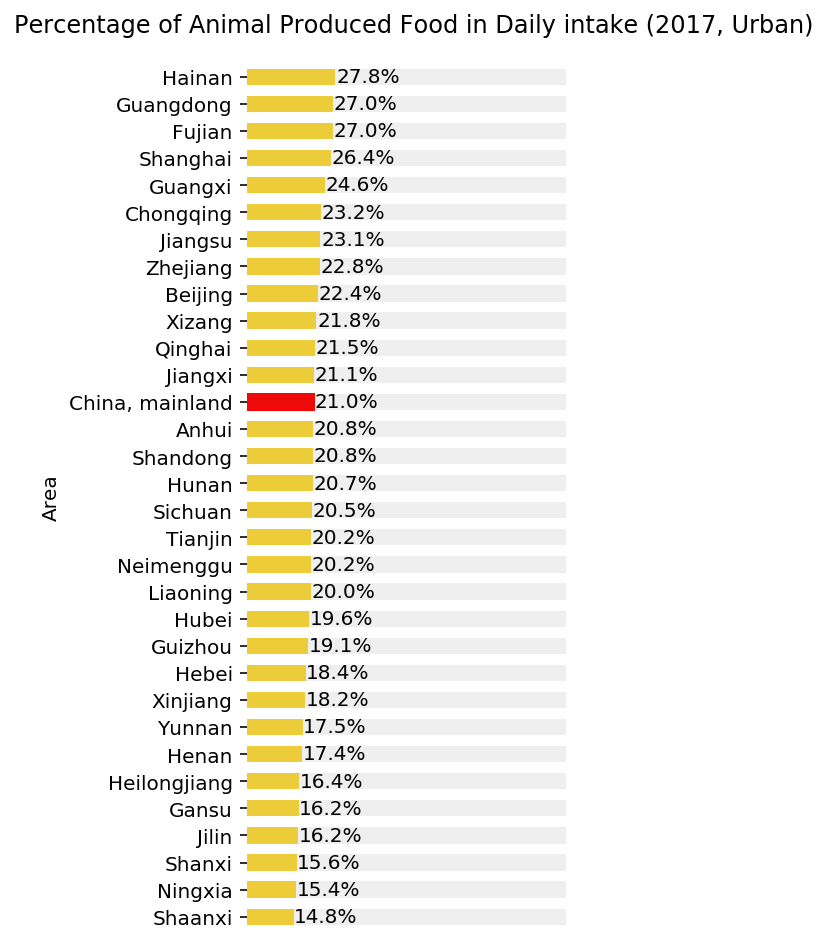

In [17]:
pc_consumption(
    urban_or_rural = 'Urban',
    year = 2017,
)

,Area,Animal Products,Sum
0,Hainan,0.248784,1.0
1,Shanghai,0.239852,1.0
2,Guangdong,0.217380,1.0
3,Fujian,0.213061,1.0
4,Zhejiang,0.182863,1.0


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/02-Percentage of Animal Produced Food in Daily intake (2017, Rural).png


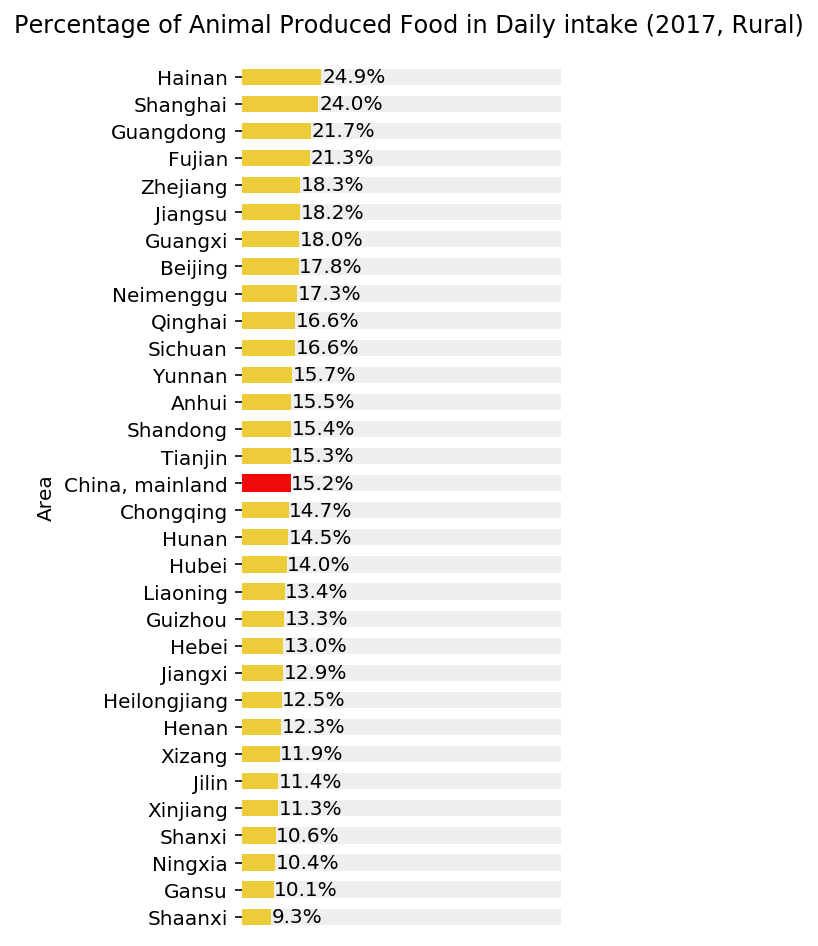

In [18]:
pc_consumption(
    urban_or_rural = 'Rural',
    year = 2017,
)

In [19]:
# 地区动物产品消费组成
def pc_animal_consumption_composition(
    urban_or_rural,
    year,
):
    df = percapita_norm.copy()
    df = df[df['Urban or Rural']==urban_or_rural]
    
    df=df[~df['Area'].isin(['China, mainland'])]
    
    df = df[[
        'Area',
        'Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk',
        'Animal Products'
    ]]
    
    df = df.sort_values(['Animal Products'], ascending=False, axis=0)
    df.reset_index(inplace=True, drop=True)
    display(df.head())

    fig_size = FIG_size
    title = f"Animal Produced Food Composition ({year}, {urban_or_rural})"
    fig = plt.figure(figsize = fig_size,dpi=DPI)
    plt.title(title,  fontsize=TIT_size, y=1.02)

    df[['Area', 'Animal Products']].plot.barh(x='Area', width=0.6, ax=plt.gca())
    
    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.1%}'.format(width), (x+width*1.01, y+0.5), fontsize=LEG_size)

    df[['Area', 
        'Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk'
       ]].plot.barh(x='Area', width=0.6, stacked=True, color=CLs, ax=plt.gca())
    
    plt.xticks([])

    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_legend().remove()
    
    ax = plt.gca().invert_yaxis()

     # === Save img
    path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'+f'02-{title}'+'.png'
    bbox = matplotlib.transforms.Bbox([[-1.5, 0], [fig_size[0]+1, fig_size[1]]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

,Area,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Animal Products
0,Hainan,0.080070,0.007833,0.002901,0.066435,0.085292,0.015956,0.019147,0.277633
1,Guangdong,0.082264,0.007293,0.002625,0.056301,0.071470,0.022170,0.028296,0.270420
2,Fujian,0.075893,0.007143,0.002679,0.031845,0.085714,0.027381,0.039286,0.269940
3,Shanghai,0.052749,0.008652,0.002512,0.035445,0.073960,0.029863,0.060843,0.264025
4,Guangxi,0.085622,0.009351,0.003507,0.058738,0.041788,0.018703,0.028054,0.245763


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/02-Animal Produced Food Composition (2017, Urban).png


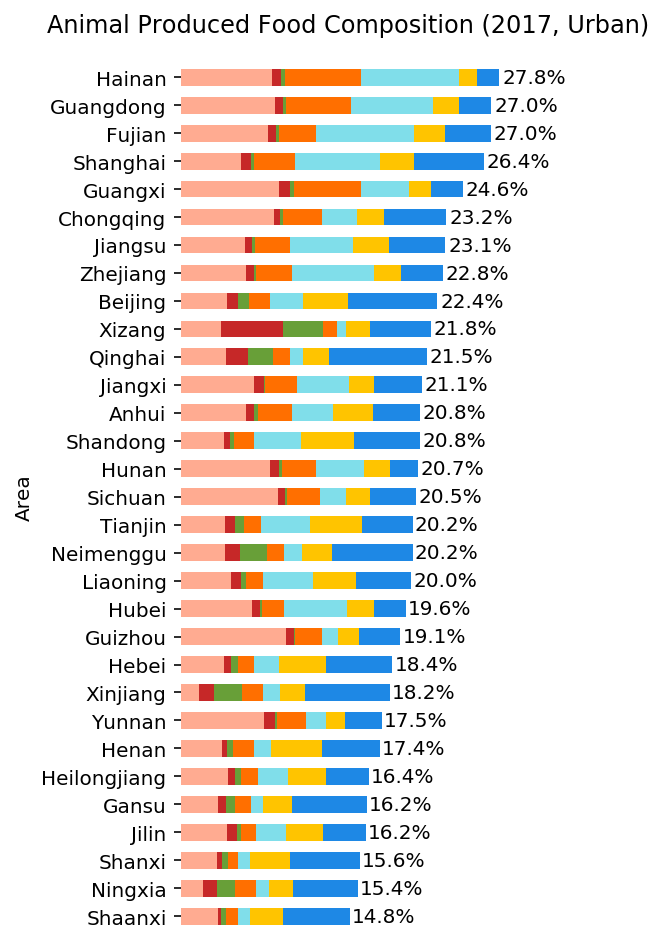

In [20]:
pc_animal_consumption_composition(
    urban_or_rural = 'Urban',
    year = 2017,
)

,Area,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Animal Products
0,Hainan,0.081556,0.003367,0.001496,0.065470,0.079312,0.012720,0.004863,0.248784
1,Shanghai,0.068408,0.004825,0.002838,0.038036,0.063298,0.028385,0.034062,0.239852
2,Guangdong,0.079001,0.002803,0.001019,0.059888,0.048930,0.017329,0.008410,0.217380
3,Fujian,0.072381,0.002993,0.001633,0.037007,0.057959,0.021769,0.019320,0.213061
4,Zhejiang,0.060345,0.003396,0.001306,0.023511,0.048589,0.021160,0.024556,0.182863


Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/02-Animal Produced Food Composition (2017, Rural).png


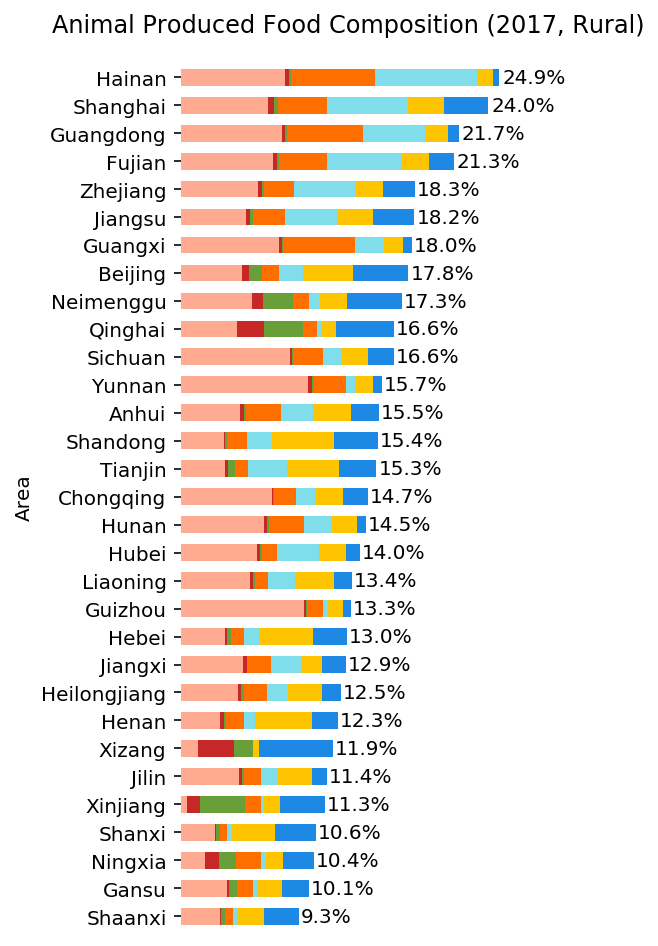

In [21]:
pc_animal_consumption_composition(
    urban_or_rural = 'Rural',
    year = 2017,
)

### 分类别不同地区动物产品摄入量占食物摄入量的比例

In [22]:
def pc_animal_consumptions_sorted_bar(
    urban_or_rural,
    year,
):
    df = percapita_norm.copy()
    df = df[df['Urban or Rural']==urban_or_rural]
    
    items = ['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk',]
    
    df = df[[
        'Area',
        'Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk',
    ]]
    
    for i, c in zip(items, CLs):
    
        df = df.sort_values([i], ascending=False, axis=0)
        df.reset_index(inplace=True, drop=True)
        
        nation_indexes = df.index[df['Area']=='China, mainland'].tolist()
        national_everage_index = nation_indexes[0]

        fig_size = FIG_size
        title = f"Percentage of {i} in Daily intake ({year}, {urban_or_rural})"
        fig = plt.figure(figsize = fig_size, dpi=DPI)
        plt.title(title,  fontsize=TIT_size)


        df[['Area', i]].plot.barh(x='Area', width=0.6, color=c, ax=plt.gca())

        ax = plt.gca()
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.1%}'.format(width), (x+width*1.01, y+0.5), fontsize=LEG_size)
        ax.patches[national_everage_index].set_ec('r')
        ax.patches[national_everage_index].set_fc('r')

       
        plt.xticks([])

        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_legend().remove()

        ax = plt.gca().invert_yaxis()

         # === Save img
        path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/img/'+f'03-{title}'+'.png'
        bbox = matplotlib.transforms.Bbox([[-1.5, 0], [fig_size[0]+1.5, fig_size[1]]])
        fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
        print('Img saved as: ' + path)

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Pigmeat in Daily intake (2017, Urban).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Bovine Meat in Daily intake (2017, Urban).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Mutton & Goat Meat in Daily intake (2017, Urban).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Poultry Meat in Daily intake (2017, Urban).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Fish, Seafood in Daily intake (2017, Urban).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Eggs in Daily intake (2017, Urban).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/

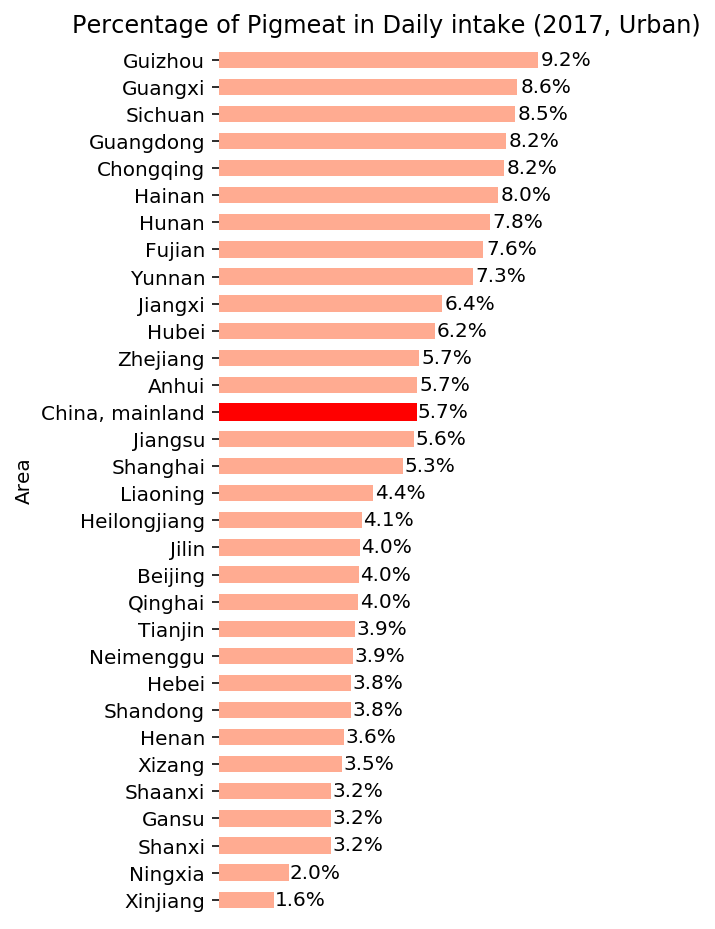

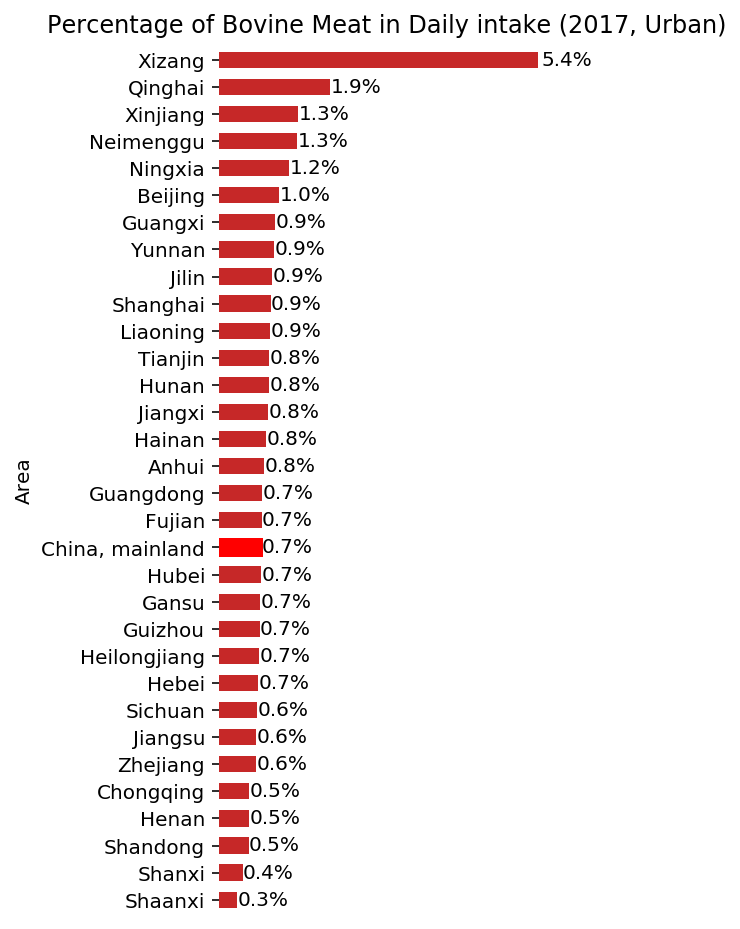

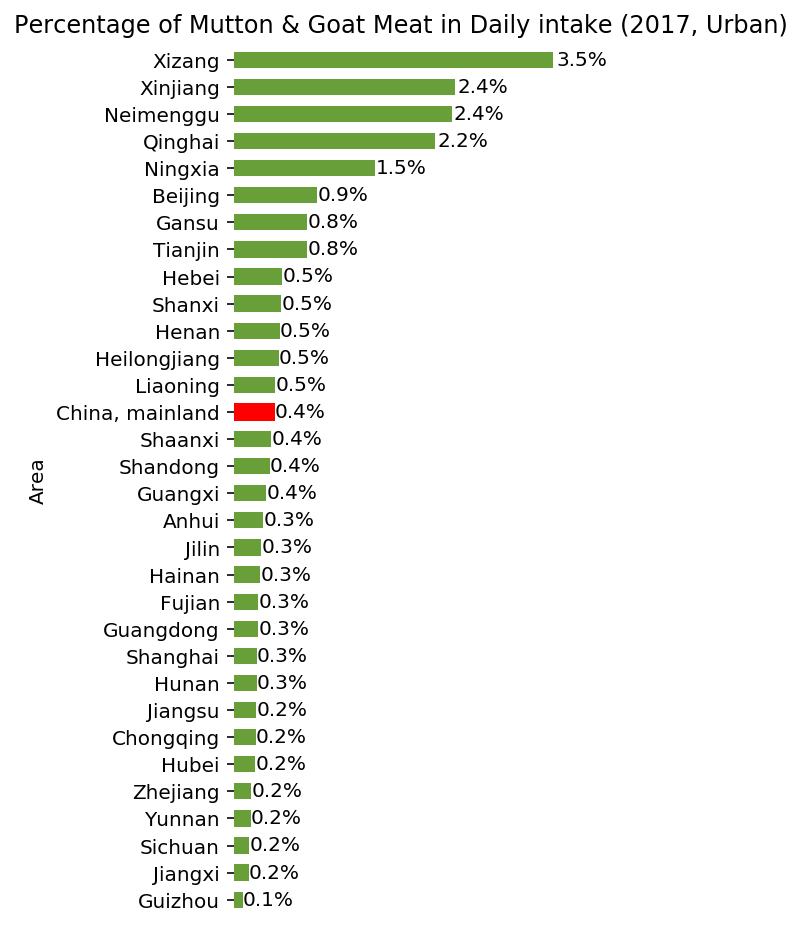

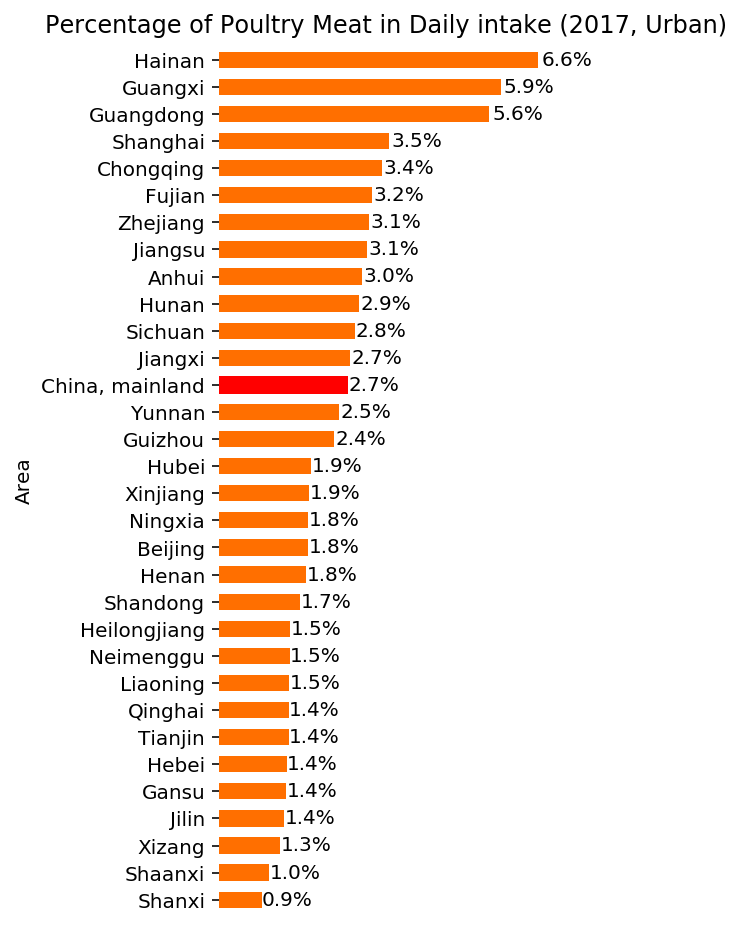

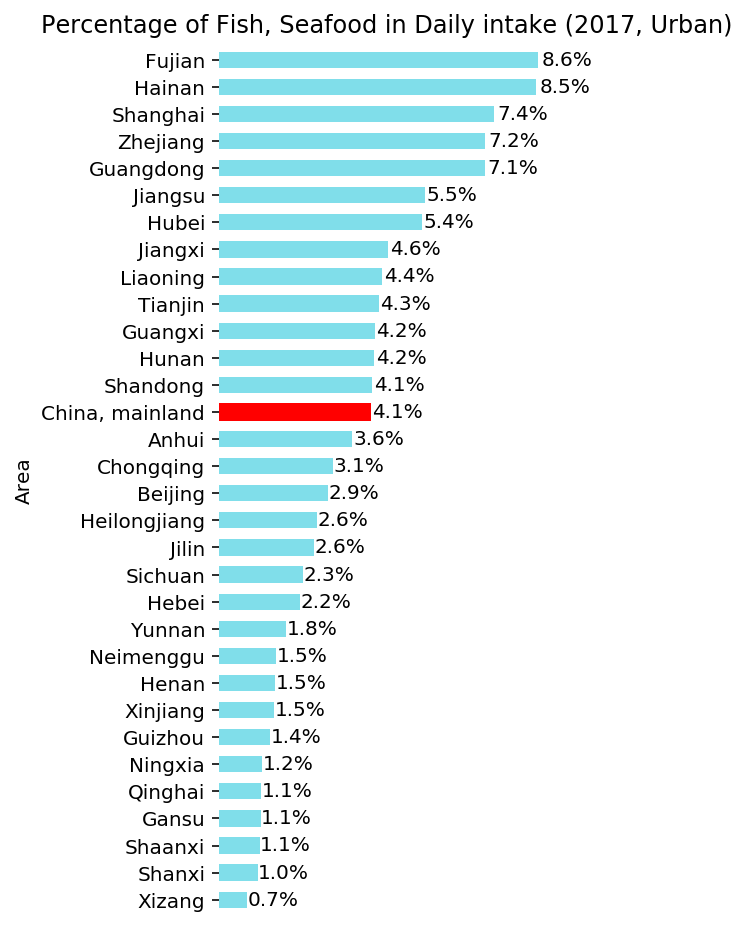

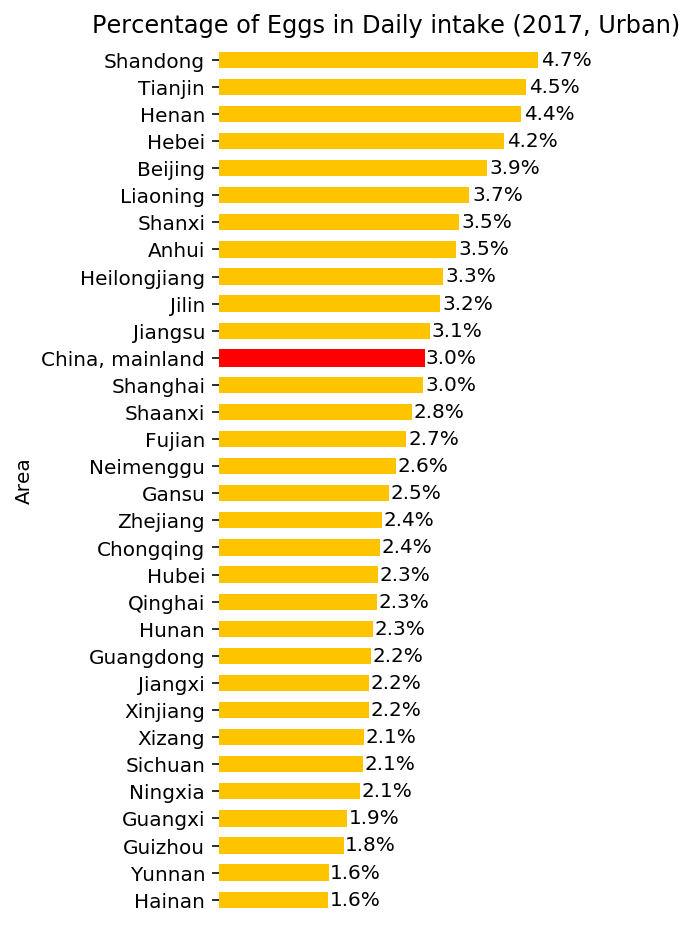

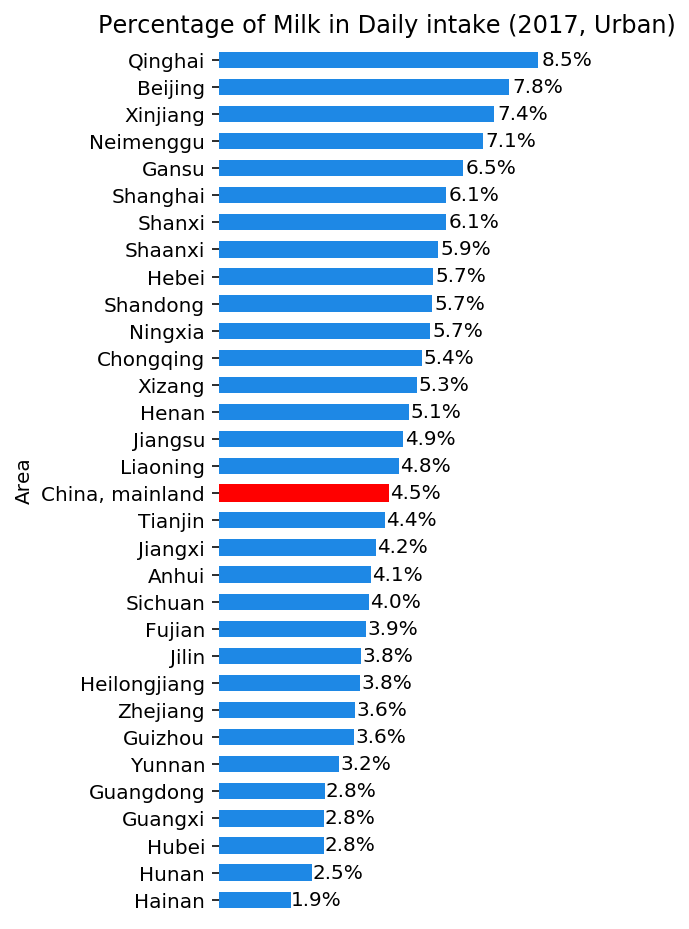

In [23]:
pc_animal_consumptions_sorted_bar(
    urban_or_rural='Urban',
    year=2017,
)

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Pigmeat in Daily intake (2017, Rural).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Bovine Meat in Daily intake (2017, Rural).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Mutton & Goat Meat in Daily intake (2017, Rural).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Poultry Meat in Daily intake (2017, Rural).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Fish, Seafood in Daily intake (2017, Rural).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/03-Percentage of Eggs in Daily intake (2017, Rural).png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/img/

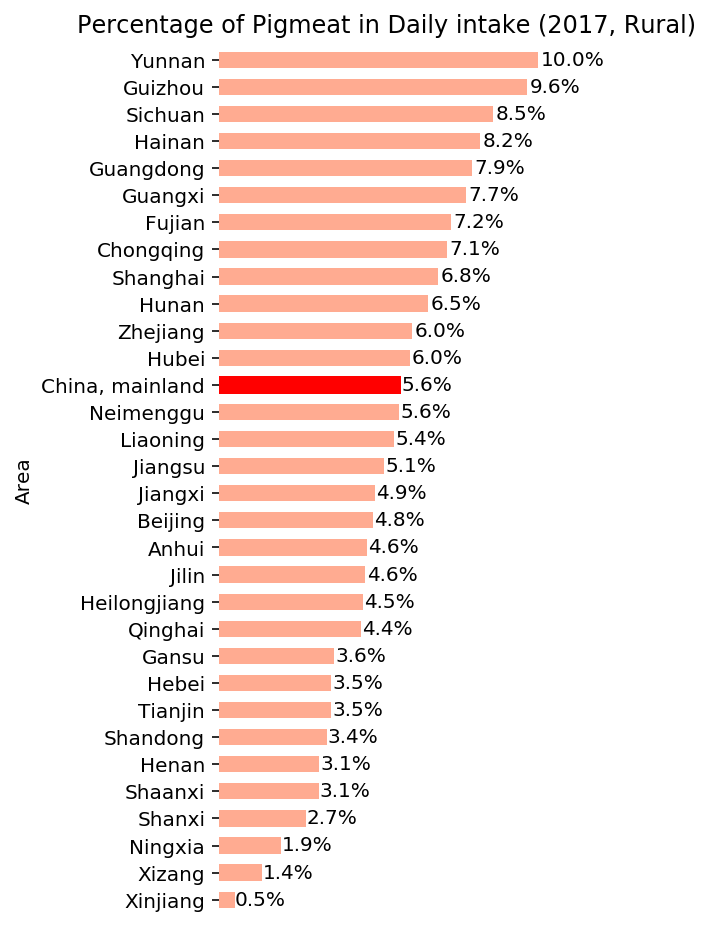

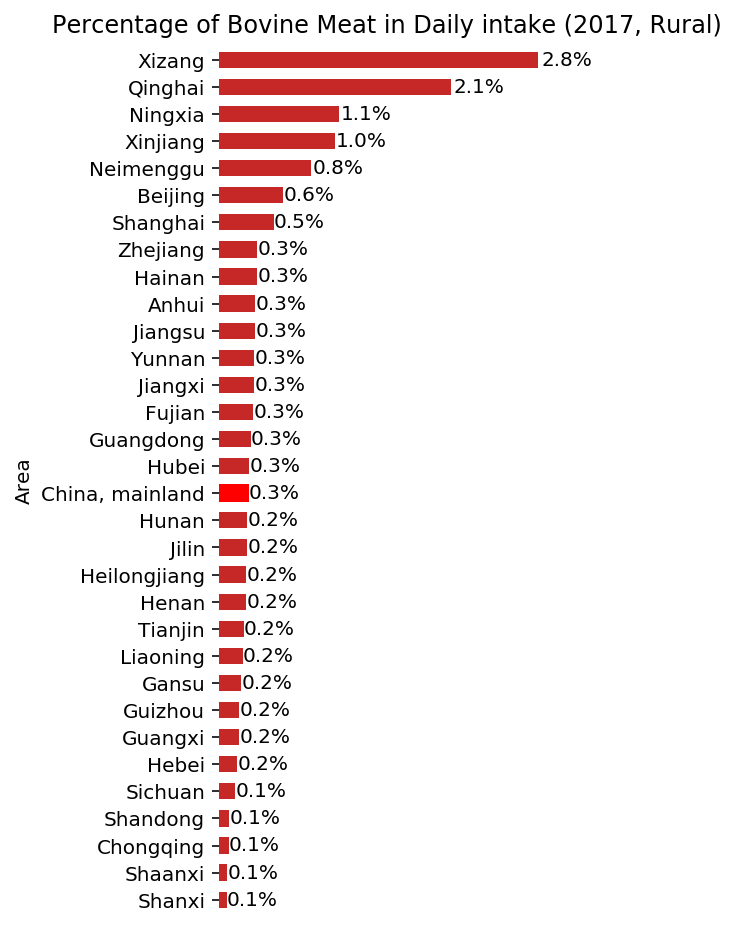

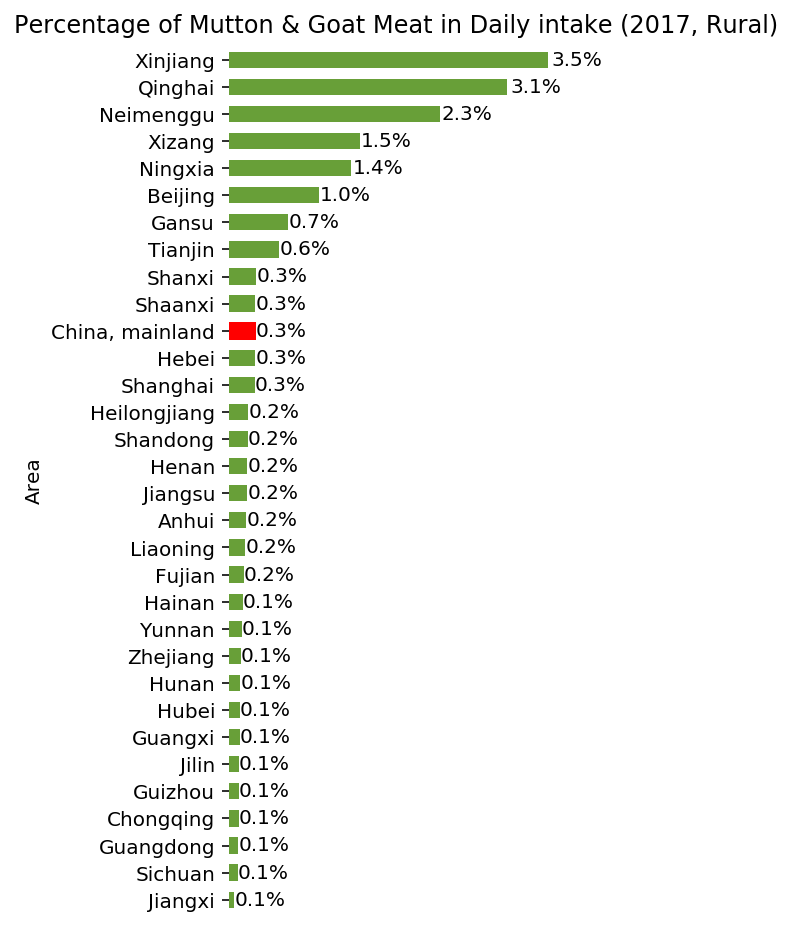

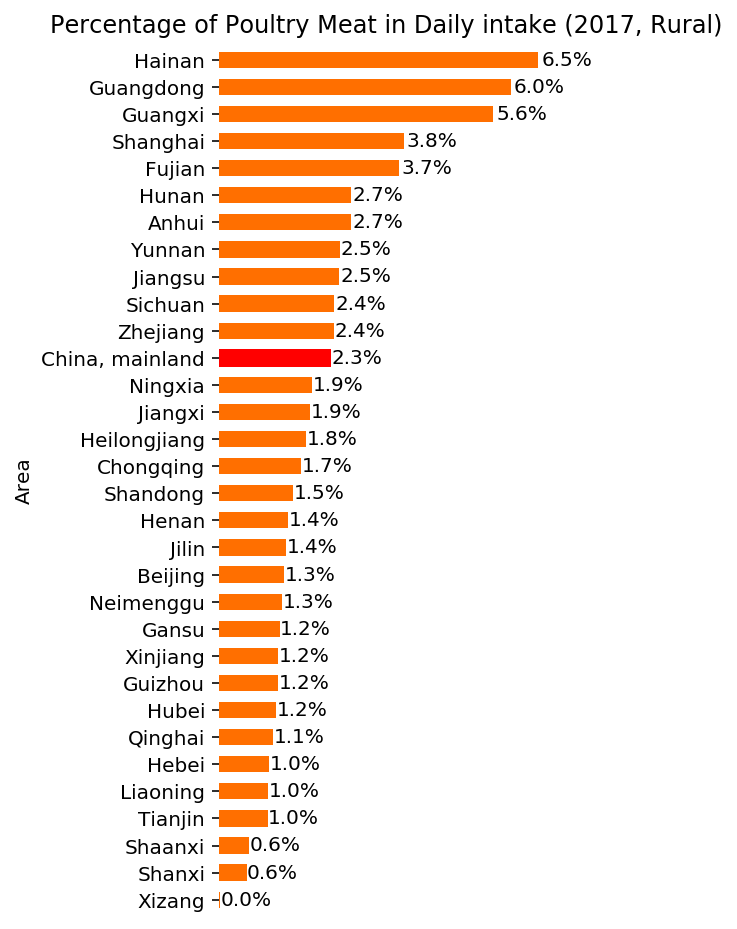

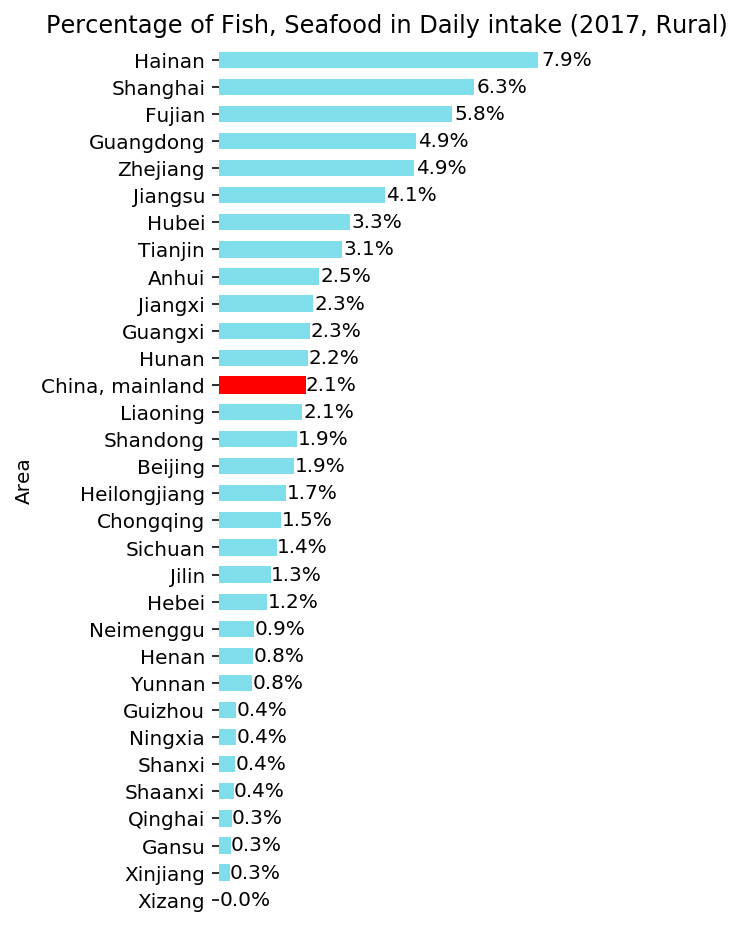

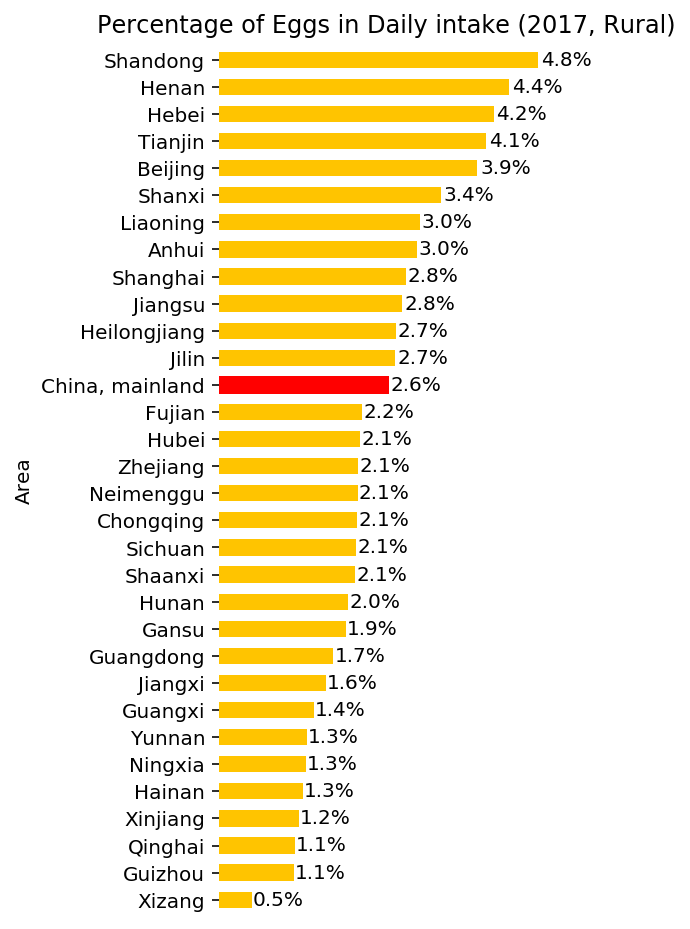

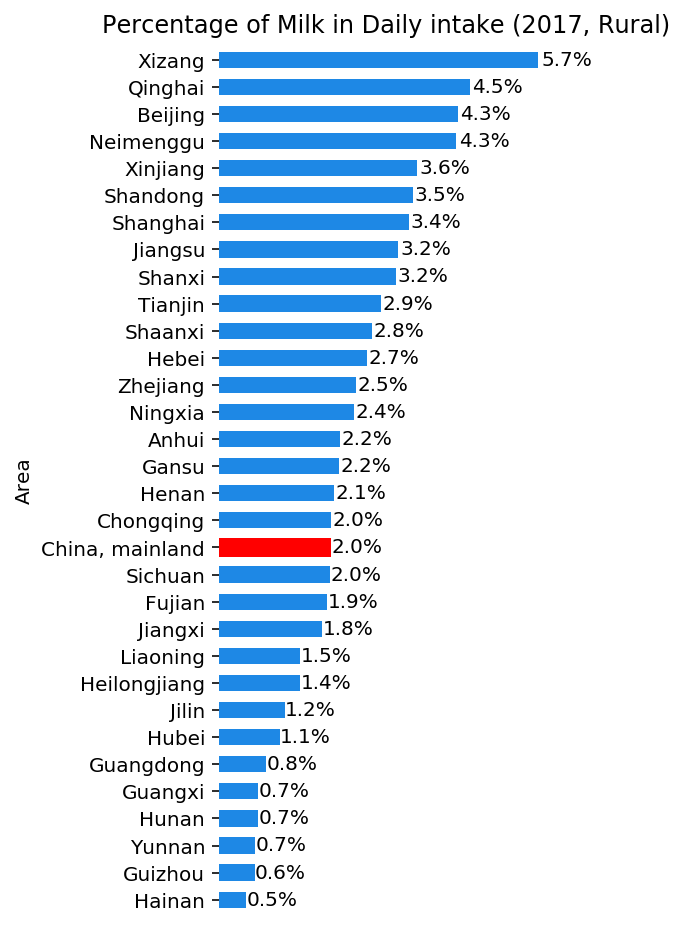

In [24]:
pc_animal_consumptions_sorted_bar(
    urban_or_rural='Rural',
    year=2017,
)

In [25]:
def plotAtlas2(
    urban_or_rural,
    items_,        # string, selected item
    year_,         # int, selected year
    geo_data_,     # geojson file
    fill_color_,   # string, select a fill_color strategy in folium
):

    df_both = percapita_norm.copy()
    df_both = df_both[df_both['Year']==year_][['Area','Urban or Rural']+items_]
    df_both[items_] =df_both[items_] * 100
    df = df_both[df_both['Urban or Rural'] == urban_or_rural]

    
    for i in items_:
        title = f"Percentage of {i} in Daily intake ({year_}, {urban_or_rural})"
        cn_map = folium.Map( width=1000, height=600, location=[40, 105], zoom_start=4, tiles='Mapbox Bright')

        threshold_scale = np.around(np.linspace(0.0, df_both[i].values.max()+1, num=6, endpoint=True),1)
        
        folium.Choropleth(
            geo_data=geo_data_,
            data=df[['Area', i]],
            name = i,
            columns=['Area', i],
            key_on='feature.properties.NAME',
            threshold_scale=threshold_scale,
            nan_fill_color='gray',
            fill_color=fill_color_,
            fill_opacity=1, 
            line_opacity=0.2,
            legend_name=title,
            show=False,
            highlight=False,
            reset=False
        ).add_to(cn_map)
        
        path = f'{LOCAL_ROOT}/results/CN_FoodConsumption/map/'+f'03-{title}'+'.html'
        cn_map.save(path)
        print('Atala saved as: ' + path)
#         display(cn_map)


#### Atlas for Urban

__注意：下个cell输出结果为地图，不能直接在文本中显示地图，请根据结果输出的地址自行查看__

In [26]:
plotAtlas2(
    urban_or_rural='Urban',
    items_= ['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk',],
    year_ = 2017,
    geo_data_=f'{LOCAL_ROOT}/geojson/cn_provinces.geojson',
    fill_color_='YlOrBr',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Pigmeat in Daily intake (2017, Urban).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Bovine Meat in Daily intake (2017, Urban).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Mutton & Goat Meat in Daily intake (2017, Urban).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Poultry Meat in Daily intake (2017, Urban).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Fish, Seafood in Daily intake (2017, Urban).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Eggs in Daily intake (2017, Urban).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_

__注意：下个cell输出结果为地图，不能直接在文本中显示地图，请根据结果输出的地址自行查看__

In [27]:
plotAtlas2(
    urban_or_rural='Rural',
    items_= ['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk',],
    year_ = 2017,
    geo_data_=f'{LOCAL_ROOT}/geojson/cn_provinces.geojson',
    fill_color_='YlOrBr',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Pigmeat in Daily intake (2017, Rural).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Bovine Meat in Daily intake (2017, Rural).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Mutton & Goat Meat in Daily intake (2017, Rural).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Poultry Meat in Daily intake (2017, Rural).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Fish, Seafood in Daily intake (2017, Rural).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_FoodConsumption/map/03-Percentage of Eggs in Daily intake (2017, Rural).html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/CN_